# 截面计算

  Li -  4 ug/cm2 
 6Li - 0.3 ug/cm2      6 g/mol
 7Li -  3.7 ug/cm2      7 g/mol
  C -  22 ug/cm2      12 g/mol
  F -  11 ug/cm2       19 g/mol

$\cfrac{N_{sc}(11B+10B)}{N_{sc}(C)} = \cfrac{\cfrac{16.40}{10.81}*\sigma_{sc}(pB)}{\cfrac{6.50}{12.01}*\sigma_{sc}(pC)}$

$\cfrac{N_{sc}(^{11}B+^{10}B+^{12}C)}{N_\alpha(\theta)} = \cfrac{\cfrac{16.40\ ug/cm^2 \times 80.1\%}{11\ g/mol}*\sigma_{sc}(p^{11}B)+\cfrac{16.40\ ug/cm^2 \times 19.9\%}{10\ g/mol}*\sigma_{sc}(p^{10}B)+\cfrac{6.50\ ug/cm^2}{12\ g/mol}*\sigma_{sc}(p^{12}C)}{\cfrac{16.40\ ug/cm^2 \times 80.1\%}{11\ g/mol}*\sigma_\alpha(\theta)}$

$\cfrac{N_{sc}(^{6}Li+^{7}Li)}{N_\alpha(\theta)} = \cfrac{\cfrac{0.3\ ug/cm^2}{6\ g/mol}*\sigma_{sc}(p^{6}Li)+\cfrac{3.7\ ug/cm^2 }{7\ g/mol}*\sigma_{sc}(p^{7}Li)}{\cfrac{3.7\ ug/cm^2}{7\ g/mol}*\sigma_\alpha(\theta)}$

$\cfrac{N_{sc}(11B+10B)+N_{sc}(12C)}{N_{sc}(Fe)} = \cfrac{\cfrac{16.40}{10.81}*\sigma_{sc}(pB)+\cfrac{6.50}{12.01}*\sigma_{sc}(pC)}{\cfrac{Fe_{thickness}}{55.85}*\sigma_{sc}(pFe)}$

In [1]:
const int Nrun = 1;
const int run[Nrun] = {5394};

In [2]:
TFile *ipf[Nrun];
for (int irun = 0; irun < Nrun; irun++)
    ipf[irun] = new TFile(Form("5Draw/ana_%d_W100.root",run[irun]));
TH1I *h;
TCanvas *c1 = new TCanvas;
gStyle->SetOptStat(0);

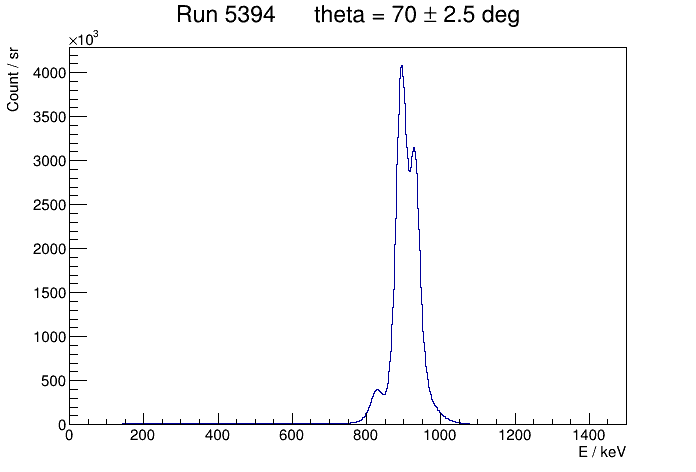

In [3]:
//%jsroot on
if (h) delete h;
theta = 70;
h = (TH1I*)ipf[0]->Get(Form("hstheta/hsingle_%ddeg",theta));
for (int irun = 1; irun < Nrun; irun++)
    h->Add( (TH1I*)ipf[irun]->Get(Form("hstheta/hsingle_%ddeg",theta)) );
h->GetXaxis()->SetTitle("E / keV");
h->GetYaxis()->SetTitle("Count / sr");
h->SetTitle("Run 5394      theta = 70 #pm 2.5 deg");
h->GetXaxis()->SetRangeUser(0,1500);
h->Draw();
c1->Draw();

In [4]:
vector<double> e;            //e[0]为目标峰，其他为周围峰
double k,b;                  //线性本底参数
double fit_left,fit_right;   //联合拟合范围
double area_left,area_right; //峰面积计算范围

In [5]:
void area(TH1I *h)
{
    c1->Clear();
    h->GetXaxis()->SetRangeUser(550,1300);   //返回全区间，在多次进行拟合时，必须要有这个操作，否则指定的拟合区间将存在问题

    //设置拟合函数：线性本底 + npeaks个高斯函数
    int npeaks = e.size();
    TString sf = "pol1(0)";
    for (int i=0; i<npeaks; i++)
        sf += Form("+gaus(%d)",3*i+2);
    TF1* f = new TF1("f", sf, fit_left, fit_right);
    f->FixParameter(0, b);                         //手动设置线性本底
    f->FixParameter(1, k);
    for (int i=0; i<npeaks; i++){
        f->SetParameter(3*i+2, 1e6);               //峰高
        f->SetParLimits(3*i+2, 1, 1e10);
        f->SetParameter(3*i+3, e[i]);              //峰中心
        f->SetParLimits(3*i+3, e[i]-10, e[i]+10);
        f->SetParameter(3*i+4, 8);                 //峰宽sigma
        f->SetParLimits(3*i+4, 5, 20);
    }
    
    TFitResultPtr fh = h->Fit(f, "QRS");
    f->SetLineColor(kRed);
    f->Draw("same");

    //单独提出线性本底
    TF1 *f1 = new TF1("f1", "pol1", 0, 2000);
    f1->SetParameter(0, f->GetParameter(0));
    f1->SetParameter(1, f->GetParameter(1));
    f1->SetLineColor(kBlue);
    f1->Draw("same");
    
    //提出联合拟合结果中的各个高斯峰
    TF1 *fg[npeaks];
    for (int i=0; i<npeaks; i++){
        fg[i] = new TF1(Form("fg%d",i), "gaus");
        fg[i]->SetParameter(0, f->GetParameter(3*i+2));
        fg[i]->SetParameter(1, f->GetParameter(3*i+3));
        fg[i]->SetParameter(2, f->GetParameter(3*i+4));
    }
    
    //计算峰面积
    int bin1 = h->FindBin(area_left);
    int bin2 = h->FindBin(area_right);
    double nall = h->Integral(bin1, bin2);                     //包含本底的总计数
    
    double x1 = h->GetBinLowEdge(bin1);                        //积分下界
    double x2 = h->GetBinLowEdge(bin2)+h->GetBinWidth(bin2);   //积分上界，注意使用了与TH1完全相等的积分范围
    double nbg = f1->Integral(x1, x2)/h->GetBinWidth(bin2);    //线性本底贡献

    //输出结果
    cout<<"count="<<nall-nbg<<" delta_count="<<sqrt(nall+nbg)<<endl;
    for (int i=0; i<npeaks; i++)
        cout<<i<<" peak="<<fg[i]->GetParameter(1)<<" height="<<fg[i]->GetParameter(0)
        <<" sigma="<<fg[i]->GetParameter(2)<<" contribution="<<fg[i]->Integral(e[i]-500,e[i]+500)/h->GetBinWidth(1)<<'\n';
    
}

In [6]:
%jsroot off

count=1.38746e+08 delta_count=12194.5
0 peak=831.859 height=370374 sigma=20 contribution=9.28391e+06
1 peak=894.765 height=3.89389e+06 sigma=15.8916 contribution=7.75551e+07
2 peak=932.237 height=2.76322e+06 sigma=13.106 contribution=4.53883e+07


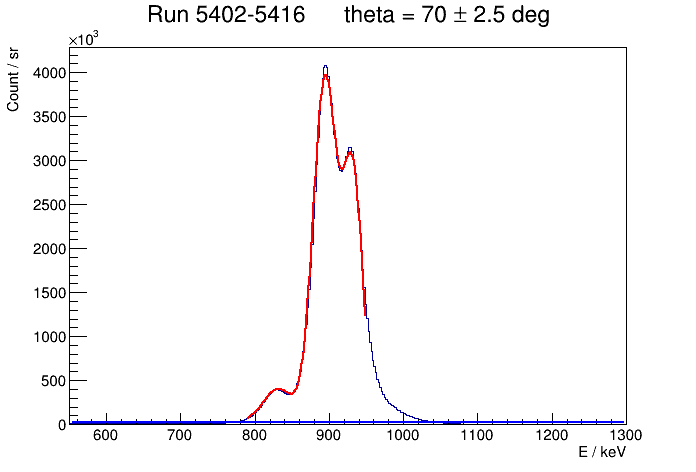

In [8]:
e = vector<double> {830, 896, 932};  // 70 deg
//e = vector<double> {834, 878, 960};  // 90 deg
k = 0; b = 30e3;                      //线性本底参数
fit_left = 790; fit_right = 950;       //联合拟合范围  70 deg
//fit_left = 810; fit_right = 980;       //联合拟合范围  90 deg
area_left = 770; area_right = 1100;
area(h);
h->GetXaxis()->SetTitle("E / keV");
h->GetYaxis()->SetTitle("Count / sr");
h->SetTitle("Run 5402-5416      theta = 70 #pm 2.5 deg");
c1->Draw();